In [30]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
torch.set_printoptions(edgeitems=2)

In [31]:
#importing dataset
housing = pd.DataFrame(pd.read_csv("Housing.csv")) 
housing.head() 

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [32]:
#dataset length
m = len(housing) 
m 

545

In [33]:
#slicing out desired features from dataset
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price'] 
Newtrain = housing[num_vars] 
Newtrain.head() 
Newtrain.shape

(545, 6)

In [34]:
#setting values of x1-5 = price influences/features
x5=torch.tensor(Newtrain['area'], dtype=torch.float)
x4=torch.tensor(Newtrain['bedrooms'], dtype=torch.float)
x3=torch.tensor(Newtrain['bathrooms'], dtype=torch.float)
x2=torch.tensor(Newtrain['stories'], dtype=torch.float)
x1=torch.tensor(Newtrain['parking'], dtype=torch.float)

#normalizing x1-x5
x1_mean=torch.mean(x1,dim=0)
x1_var=torch.var(x1,dim=0)
x1=(x1-x1_mean)/torch.sqrt(x1_var)

x2_mean=torch.mean(x2,dim=0)
x2_var=torch.var(x2,dim=0)
x2=(x2-x2_mean)/torch.sqrt(x2_var)

x3_mean=torch.mean(x3,dim=0)
x3_var=torch.var(x3,dim=0)
x3=(x3-x3_mean)/torch.sqrt(x3_var)

x4_mean=torch.mean(x4,dim=0)
x4_var=torch.var(x4,dim=0)
x4=(x4-x4_mean)/torch.sqrt(x4_var)

x5_mean=torch.mean(x5,dim=0)
x5_var=torch.var(x5,dim=0)
x5=(x5-x5_mean)/torch.sqrt(x5_var)

In [35]:
#setting price as the validation output u
#normalizing u
u=torch.tensor(Newtrain['price'], dtype=torch.float)
u_mean=torch.mean(u,dim=0)
u_var=torch.var(u,dim=0)
u=(u-u_mean)/torch.sqrt(u_var)

In [36]:
#defining linear model, note that w1-5 and b are the parameters 
def model(w5,w4,w3,w2,w1,b,x5,x4,x3,x2,x1):
    return w5*x5*5+w4*x4*4+w3*x3*3+w2*x2*2+w1*x1+b

In [37]:
#loss function, difference between predicted value and true validation value u
def loss_fn(wx, u):
    squared_diffs = (wx - u)**2
    return squared_diffs.mean()

In [38]:
#initializing params(w5-w1 and b)
params = torch.tensor([1.0,1,1,1,1,1], requires_grad=True)

In [39]:
params.grad is None

True

In [40]:
params.dtype

torch.float32

In [41]:
#defining loss
loss = loss_fn(model(*params,x5,x4,x3,x2,x1), u)
loss.backward()

In [42]:
#new params
params.grad

tensor([61.6254, 51.6729, 34.5990, 18.5961,  7.1093,  2.0000])

In [47]:
if params.grad is not None:
    params.grad.zero_()

In [44]:
#defining the training loop
def training_loop(n_epochs, learning_rate, params, wx, u):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  
            params.grad.zero_()
        
        wx = model(*params,x5,x4,x3,x2,x1) 
        loss = loss_fn(wx, u)
        loss.backward()
        
        with torch.no_grad(): 
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [54]:
#running the training to determine best params for linear model 
params=training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-3, 
    params = torch.tensor([1.0,0,0,0,0,0], requires_grad=True),
    wx = model(*params,x5,x4,x3,x2,x1), 
    u = u)

Epoch 500, Loss 0.446237
Epoch 1000, Loss 0.439173
Epoch 1500, Loss 0.437897
Epoch 2000, Loss 0.437665
Epoch 2500, Loss 0.437622
Epoch 3000, Loss 0.437615
Epoch 3500, Loss 0.437613
Epoch 4000, Loss 0.437613
Epoch 4500, Loss 0.437613
Epoch 5000, Loss 0.437613


In [55]:
#viewing params(w5-w1 and b)
params

tensor([ 7.6837e-02,  1.6555e-02,  1.0152e-01,  1.2706e-01,  1.7389e-01,
        -8.5093e-08], requires_grad=True)

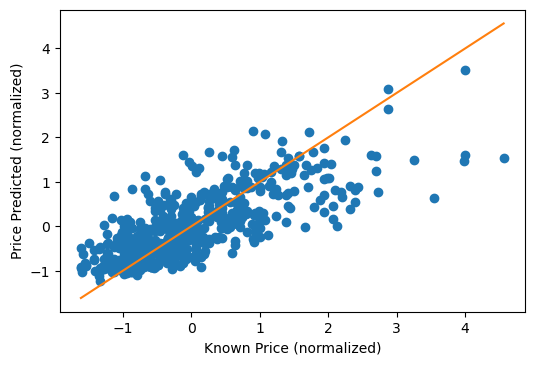

In [56]:
#plotting prediction vs validation
#Perfect prediction would follow the orange line, y=1x+0
from matplotlib import pyplot as plt

wx = model(*params,x5,x4,x3,x2,x1) 

fig = plt.figure(dpi=100)
plt.xlabel("Known Price (normalized)")
plt.ylabel("Price Predicted (normalized)")
plt.plot(u.numpy(), wx.detach().numpy(), 'o') 
plt.plot(u.numpy(), u.numpy())
plt.savefig("Price.png", format="png") 